# Tune resonance diagram

In [1]:
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# https://gitlab.cce.kfa-juelich.de/BCC/Tune/fastTune/fasttune-gui/-/blob/master/src/tuneresonances.py
import math

def x(y, l, m, p):
    return (p - m*y)*1./l if l != 0 else None

def y(x, l, m, p):
    return (p - l*x)*1./m if m != 0 else None

def endpoints(box, *lmp):
    """Returns the two points where a resonance line crosses the edges of the L-R-B-T-box (or None if outside)"""
    L,R,B,T = box
    points = []
    X = x(B, *lmp)
    if X is not None and L <= X < R:  # resonance line crosses BOTTOM edge
        points.append((X, B))
    X = x(T, *lmp)
    if X is not None and L < X <= R:  # resonance line crosses TOP edge
        points.append((X, T))
    Y = y(L, *lmp)
    if Y is not None and B < Y <= T:  # resonance line crosses LEFT edge
        points.append((L, Y))
    Y = y(R, *lmp)
    if Y is not None and B <= Y < T:  # resonance line crosses RIGHT edge
        points.append((R, Y))
    return None if len(points) < 2 else points

def edgepath(box, p0, p):
    """returns intermidate points to get a line following the edges of the L-R-B-T-box"""
    L,R,B,T = box
    (x1, y1), (x2, y2) = p0, p
    # if points on same edge
    if x1 == x2 == L or x1 == x2 == R or\
        y1 == y2 == B or y1 == y2 == T:
            return []
    # if points on adjacent edges
    for X,nX in ((L,R),(R,L)):
        for Y,nY in ((T,B),(B,T)):
            if x1 == X and y2 == Y or y1 == Y and x2 == X:
                return [(X,Y)]
    # if points on opposite edges (L-R or T-B)
    if (x1,x2) == (L,R) or (x1,x2) == (R,L):
        return [(x1,B),(x2,B)]
    if (y1,y2) == (T,B) or (y1,y2) == (B,T):
        return [(L,y1),(L,y2)]
    return []

def resonance_plot(L,R,B,T,order=None,max_order=None):
    """Returns X,Y of a contiuous line for plotting resonance lines within the L-R-B-T-box"""
    box = L,R,B,T
    lines = []
    # calculate all resonance lines
    o = order if order is not None else max_order if max_order is not None else 0
    for l in range(-o, o+1):
        for m in range(-o, o+1):
            n = abs(l)+abs(m)
            p_max = int(max(L,R,B,T)*n+1)
            if n == order or max_order is not None and n <= max_order:
                for p in range(p_max):
                    if math.gcd(math.gcd(l, m), p) > 1: continue  # harmonic of lower n
                    # l * Qx + m * Qy = p
                    line = endpoints(box, l,m,p)
                    if line and line not in lines:
                        lines.append(line)
    # flatten
    points = [(L,B),(R,B),(R,T),(L,T),(L,B)]
    for line in lines:
        if len(points) > 0:
            points.extend(edgepath(box, points[-1], line[0]))
        points.extend(line)
    # output
    X = [_[0] for _ in points]
    Y = [_[1] for _ in points]
    return X, Y

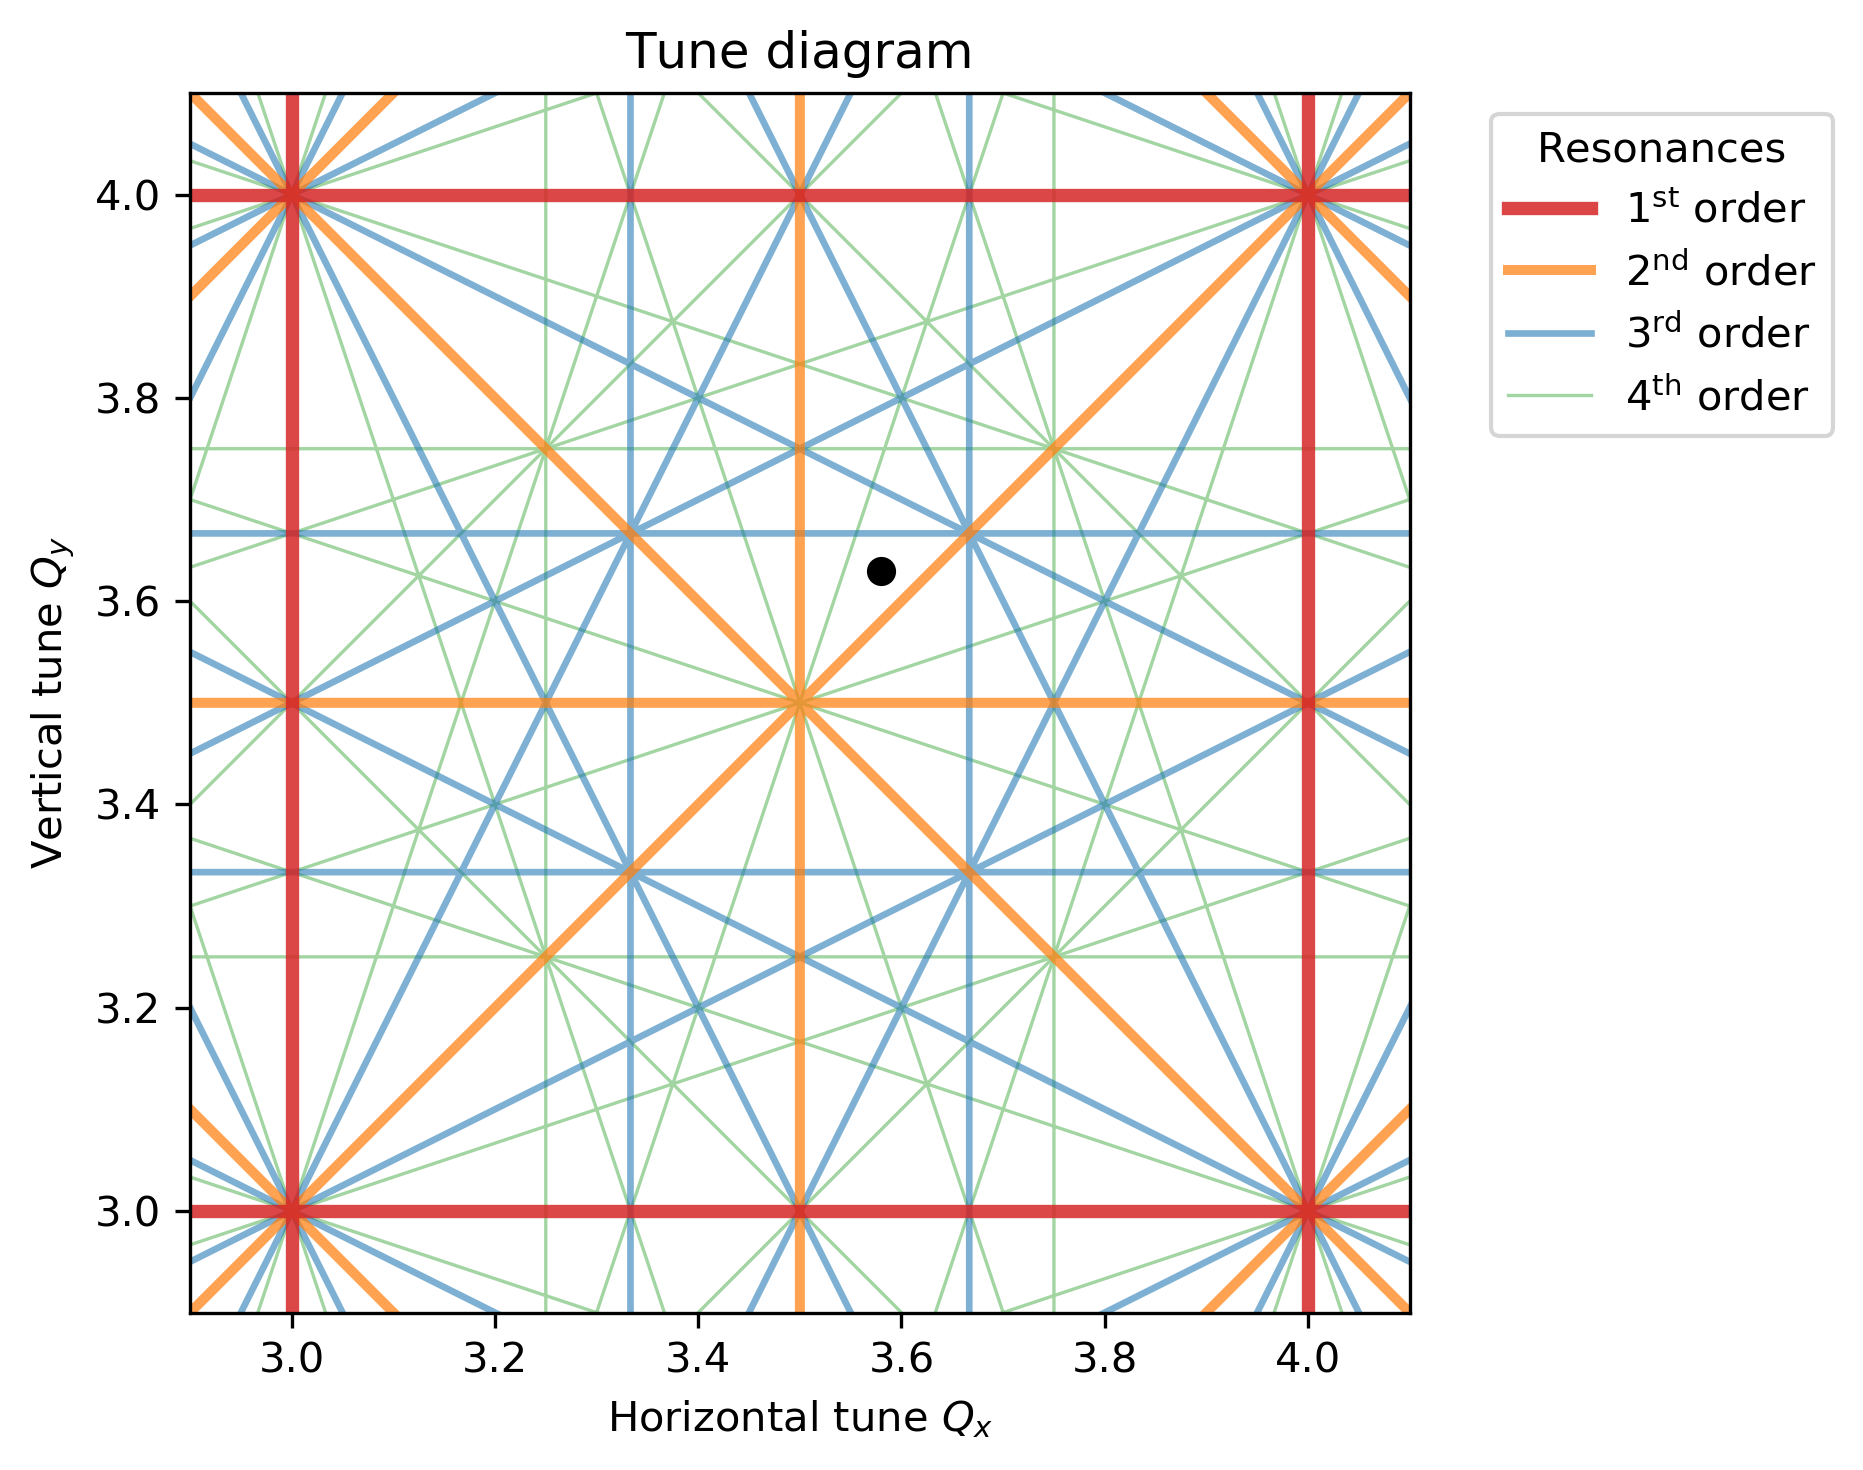

In [5]:
# tune diagram
plt.figure(figsize=(7,5), dpi=300)

box = [2.8, 4.2, 2.8, 4.2]  # draw resoances in this range
plt.xlim((2.9, 4.1))  # show this range
plt.ylim((2.9, 4.1))

max_order = 4
max_linewidth = 4
for order in range(1, max_order+1):
    plt.plot(*resonance_plot(*box, order), c='tab:'+{1:'red',2:'orange',3:'blue',4:'green',5:'olive'}[order],
              alpha=1-0.7*order/(max_order+1), linewidth=max_linewidth*(1-order/(max_order+1)),
              label='$\\mathrm{%s^{%s}}$ order'%(order, 'st' if order==1 else 'nd' if order==2 else 'rd' 
                                                 if order==3 else 'th'), zorder=-order)

# Working point
plt.plot(3.58, 3.63, 'ko')

# Plot layout
plt.legend(title='Resonances', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Tune diagram')
plt.xlabel('Horizontal tune $Q_x$')
plt.ylabel('Vertical tune $Q_y$')
plt.gca().set_aspect('equal', 'box')
plt.tight_layout()
plt.savefig('tune_resonances.pdf')